# <center> CS439 Final Project: Predicting and Contextualizing Key Factors Influencing Student Academic Performance

### <center> Collaborators: Karthik Mudakalli (km1663), Daniel Tang (dt655), Joe Kim (jk1948)

In [2]:
import os
import json
import math
import numpy as np
import pandas as pd

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

In [3]:
# Load Kaggle student performance data

spf_path = "StudentPerformanceFactors.csv"
spf = pd.read_csv(spf_path)

print("StudentPerformanceFactors shape:", spf.shape)
print(spf.head())

StudentPerformanceFactors shape: (6607, 20)
   Hours_Studied  Attendance Parental_Involvement Access_to_Resources  \
0             23          84                  Low                High   
1             19          64                  Low              Medium   
2             24          98               Medium              Medium   
3             29          89                  Low              Medium   
4             19          92               Medium              Medium   

  Extracurricular_Activities  Sleep_Hours  Previous_Scores Motivation_Level  \
0                         No            7               73              Low   
1                         No            8               59              Low   
2                        Yes            7               91           Medium   
3                        Yes            8               98           Medium   
4                        Yes            6               65           Medium   

  Internet_Access  Tutoring_Sessions Famil

In [4]:
#Load Rutgers course JSONs and departments

fall_path = "combined_courses_fall2025.json"
spring_path = "combined_courses_spring2026.json"
depts_path = "departments.json"

with open(fall_path, "r") as f:
    fall_raw = json.load(f)

with open(spring_path, "r") as f:
    spring_raw = json.load(f)

with open(depts_path, "r") as f:
    departments = json.load(f)

len(fall_raw["courseOfferings"]), len(spring_raw["courseOfferings"])


(2702, 3748)

In [5]:
# Helper to flatten course offerings into section level rows

def flatten_course_offerings(data):
    rows = []
    for course in data["courseOfferings"]:
        unit_code = course.get("offeringUnit", {}).get("code")
        subj = course.get("course", {}).get("subject")
        num = course.get("course", {}).get("number")
        core = course.get("coreCodes")
        title = course.get("title")
        full_title = course.get("fullTitle")
        credits_raw = course.get("credits")

        # Spring JSON sometimes does not have 'credits', treat as None
        credits = None
        if credits_raw not in (None, ""):
            try:
                credits = float(credits_raw)
            except Exception:
                credits = None

        sections = course.get("sections", [])
        for sec in sections:
            row = {
                "unit": unit_code,
                "subject": subj,
                "course_number": num,
                "coreCodes": core,
                "title": title,
                "fullTitle": full_title,
                "credits": credits,
            }
            # copy section fields except meetingTimes
            for k, v in sec.items():
                if k == "meetingTimes":
                    continue
                row[f"sec_{k}"] = v

            # schedule and resource features
            mtimes = sec.get("meetingTimes", [])
            days = set()
            modes = set()
            total_minutes = 0
            earliest_start = None
            latest_end = None

            for mt in mtimes:
                day = mt.get("meetingDay")
                if day:
                    days.add(day)

                sm = mt.get("startMinute")
                em = mt.get("endMinute")
                if sm and em and str(sm).isdigit() and str(em).isdigit():
                    sm_i = int(sm)
                    em_i = int(em)
                    if em_i > sm_i:
                        total_minutes += (em_i - sm_i)
                    earliest_start = sm_i if earliest_start is None else min(earliest_start, sm_i)
                    latest_end = em_i if latest_end is None else max(latest_end, em_i)

                mode_desc = mt.get("meetingModeDesc")
                if mode_desc:
                    modes.add(mode_desc)

            row["num_meeting_days"] = len(days)
            row["weekly_contact_minutes"] = total_minutes
            row["earliest_start_min"] = earliest_start
            row["latest_end_min"] = latest_end
            row["meeting_modes"] = ";".join(sorted(modes)) if modes else None

            rows.append(row)

    return pd.DataFrame(rows)

fall_sections = flatten_course_offerings(fall_raw)
spring_sections = flatten_course_offerings(spring_raw)

print("Fall sections:", fall_sections.shape)
print("Spring sections:", spring_sections.shape)
fall_sections.head()

Fall sections: (7695, 29)
Spring sections: (9758, 30)


,unit,subject,course_number,coreCodes,title,fullTitle,credits,sec_yearterm,sec_registrationIndex,sec_legendKey,...,sec_specialPermissionAdd,sec_comments,sec_instructors,sec_crossListedSections,sec_majors,num_meeting_days,weekly_contact_minutes,earliest_start_min,latest_end_min,meeting_modes
0,11,680,101,"Our Common Future (CCO), Natural Sciences (NS)",LIVING MICROBE WORLD,LIVING IN THE MICROBIAL WORLD ...,3.0,20259,15425,None,...,None,[],[{'name': 'KEDDIS'}],[],[],2,160,840.0,920.0,LEC
1,11,680,103,"Our Common Future (CCO), Natural Sciences (NS)",MICROBIAL PRODUCTS,MICROBIAL PRODUCTS IN A SUSTAINABLE GARDEN...,3.0,20259,15426,None,...,None,[],[{'name': 'ESQUILIN-LEBRON'}],[],[],1,180,840.0,1020.0,LEC
2,11,680,390,None,GENERAL MICROBIOLOGY,GENERAL MICROBIOLOGY,4.0,20259,15427,None,...,None,[ First Day Course Materials Charge. Go to: f...,"[{'name': 'ZYLSTRA, GERBEN'}, {'name': 'RAUSCH...",[],[],3,340,510.0,910.0,LAB;LEC
3,11,680,390,None,GENERAL MICROBIOLOGY,GENERAL MICROBIOLOGY,4.0,20259,15428,None,...,None,[ First Day Course Materials Charge. Go to: f...,"[{'name': 'ZYLSTRA, GERBEN'}, {'name': 'RAUSCH...",[],[],2,340,510.0,800.0,LAB;LEC
4,11,680,390,None,GENERAL MICROBIOLOGY,GENERAL MICROBIOLOGY,4.0,20259,15429,None,...,None,[ First Day Course Materials Charge. Go to: f...,"[{'name': 'ZYLSTRA, GERBEN'}, {'name': 'RAUSCH...",[],[],3,340,510.0,910.0,LAB;LEC


Want one row per course code across both terms

In [6]:
#Aggregate to course level features

course_sections = (
    pd.concat([fall_sections, spring_sections], ignore_index=True)
    .assign(
        unit=lambda d: d["unit"].astype(str).str.zfill(2),
        subject=lambda d: d["subject"].astype(str).str.zfill(3),
        course_number=lambda d: d["course_number"].astype(str).str.zfill(3),
    )
)

course_sections["course_code"] = (
    course_sections["unit"] + course_sections["subject"] + course_sections["course_number"]
)

course_features = (
    course_sections
    .groupby("course_code")
    .agg(
        unit=("unit", "first"),
        subject=("subject", "first"),
        course_number=("course_number", "first"),
        title=("title", "first"),
        credits=("credits", "first"),
        avg_weekly_contact_hours=("weekly_contact_minutes", lambda x: np.nanmean(x) / 60.0),
        avg_num_meeting_days=("num_meeting_days", "mean"),
        earliest_start_min=("earliest_start_min", "min"),
        latest_end_min=("latest_end_min", "max"),
        meeting_modes=("meeting_modes", lambda x: ";".join(sorted(set([m for m in x if isinstance(m, str)]))))
    )
    .reset_index()
)

print("Course features:", course_features.shape)
course_features.head()


Course features: (5106, 11)


,course_code,unit,subject,course_number,title,credits,avg_weekly_contact_hours,avg_num_meeting_days,earliest_start_min,latest_end_min,meeting_modes
0,01013111,01,013,111,BIBLE IN ARAMAIC,3.0,1.333333,1.0,840.0,920.0,LEC;ONLINE INSTRUCTION(INTERNET)
1,01013130,01,013,130,COMICS MIDEAST,3.0,2.666667,2.0,1170.0,1250.0,LEC
2,01013140,01,013,140,ELEMENTARY ARABIC I,4.0,2.666667,2.0,620.0,1140.0,LEC;ONLINE INSTRUCTION(INTERNET)
3,01013141,01,013,141,ELEMENTARY ARABIC II,4.0,2.666667,2.0,840.0,920.0,LEC;ONLINE INSTRUCTION(INTERNET)
4,01013143,01,013,143,ARABIC LAB 1,1.0,0.000000,0.0,NaN,NaN,ONLINE INSTRUCTION(INTERNET)


In [7]:
# Add department name and discipline

course_features["department_name"] = course_features["subject"].map(departments)

def map_discipline(dept_name: str) -> str:
    if not isinstance(dept_name, str):
        return "Other"
    name = dept_name.upper()
    if any(k in name for k in ["ENGINEERING", "MATHEMATICS", "PHYSICS", "CHEMISTRY", "BIOLOGICAL", "BIOLOGY", "COMPUTER"]):
        return "STEM"
    if any(k in name for k in ["ECONOMICS", "PSYCHOLOGY", "SOCIOLOGY", "POLITICAL", "ANTHROPOLOGY"]):
        return "Social Science"
    if any(k in name for k in ["HISTORY", "LANGUAGE", "LITERATURE", "STUDIES", "PHILOSOPHY"]):
        return "Humanities"
    if any(k in name for k in ["BUSINESS", "ACCOUNTING", "FINANCE", "MANAGEMENT", "MARKETING"]):
        return "Business"
    return "Other"

course_features["discipline"] = course_features["department_name"].apply(map_discipline)

course_features.head()


,course_code,unit,subject,course_number,title,credits,avg_weekly_contact_hours,avg_num_meeting_days,earliest_start_min,latest_end_min,meeting_modes,department_name,discipline
0,01013111,01,013,111,BIBLE IN ARAMAIC,3.0,1.333333,1.0,840.0,920.0,LEC;ONLINE INSTRUCTION(INTERNET),"AFRICAN, MIDDLE EASTERN, AND SOUTH ASIAN LANGU...",Humanities
1,01013130,01,013,130,COMICS MIDEAST,3.0,2.666667,2.0,1170.0,1250.0,LEC,"AFRICAN, MIDDLE EASTERN, AND SOUTH ASIAN LANGU...",Humanities
2,01013140,01,013,140,ELEMENTARY ARABIC I,4.0,2.666667,2.0,620.0,1140.0,LEC;ONLINE INSTRUCTION(INTERNET),"AFRICAN, MIDDLE EASTERN, AND SOUTH ASIAN LANGU...",Humanities
3,01013141,01,013,141,ELEMENTARY ARABIC II,4.0,2.666667,2.0,840.0,920.0,LEC;ONLINE INSTRUCTION(INTERNET),"AFRICAN, MIDDLE EASTERN, AND SOUTH ASIAN LANGU...",Humanities
4,01013143,01,013,143,ARABIC LAB 1,1.0,0.000000,0.0,NaN,NaN,ONLINE INSTRUCTION(INTERNET),"AFRICAN, MIDDLE EASTERN, AND SOUTH ASIAN LANGU...",Humanities


In [8]:
# Load degrees

deg_path = "degrees.csv"
deg = pd.read_csv(deg_path)

print("Degrees shape:", deg.shape)
deg.head()

Degrees shape: (508, 5)


,ID,Name,Degree Code,Start Term,requirements
0,369,Degree Audit for Engineering Five - Year,NB,Fall 2003,NaN
1,6061,Major in Social Work,NB,NaN,"[{""id"": ""R1"", ""logic"": ""and"", ""title"": ""Prereq..."
2,2394,Degree Audit for Bioenvironmental Engineering ...,NB,Fall 2019,"[{""id"": ""R1"", ""logic"": ""and"", ""title"": ""First ..."
3,4542,Applied Sciences in Engineering - Packaging Op...,NB,Fall 2020,"[{""id"": ""R1"", ""logic"": ""and"", ""title"": ""First ..."
4,372,Undeclared School of Environmental and Biologi...,NB,Fall 2007,NaN


In [9]:
#Parse requirements and extract course codes

def parse_course_code_str(code):
    """
    Return an 8 digit course code like '01119150' (unit 01, subject 119, number 150),
    ignore tokens like 'nb14_bioalt'.
    """
    if not isinstance(code, str):
        return None
    if len(code) < 8:
        return None
    prefix = code[:8]
    if not prefix.isdigit():
        return None
    return prefix

def extract_degree_course_codes(requirements_json_str):
    """
    Given the JSON string for one degree's requirements, return a sorted list of 8 digit course codes.
    """
    if pd.isna(requirements_json_str):
        return []
    try:
        blocks = json.loads(requirements_json_str)
    except Exception:
        return []
    codes = []
    for block in blocks:
        for req in block.get("requirements", []):
            for code in req.get("course_pool", []):
                parsed = parse_course_code_str(code)
                if parsed:
                    codes.append(parsed)
    return sorted(set(codes))

deg["course_codes"] = deg["requirements"].apply(extract_degree_course_codes)
deg[["Name", "course_codes"]].head(10)


,Name,course_codes
0,Degree Audit for Engineering Five - Year,[]
1,Major in Social Work,"[01119150, 01119154, 01119160, 01119182, 01830..."
2,Degree Audit for Bioenvironmental Engineering ...,"[01119103, 01160159, 01160160, 01160161, 01160..."
3,Applied Sciences in Engineering - Packaging Op...,"[01160159, 01160160, 01160171, 01160209, 01160..."
4,Undeclared School of Environmental and Biologi...,[]
5,"Degree Audit for Major in African, Middle East...","[01013201, 01013211, 01013221, 01013231, 01013..."
6,Degree Audit for Pre-med,[]
7,Degree Audit for Undeclared,[]
8,Biomedical Engineering (5 year),"[01119115, 01119117, 01160159, 01160160, 01160..."
9,Aerospace Engineering,"[01160159, 01160160, 01160171, 01355101, 01640..."


In [10]:
# Degree level summary from course level features

course_lookup = course_features.set_index("course_code")

def summarize_degree(code_list):
    rows = []
    for code in code_list:
        if code in course_lookup.index:
            rows.append(course_lookup.loc[code])
    if not rows:
        return pd.Series({
            "num_mapped_courses": 0,
            "avg_credits": np.nan,
            "avg_weekly_contact_hours": np.nan,
            "avg_num_meeting_days": np.nan,
        })
    df = pd.DataFrame(rows)
    return pd.Series({
        "num_mapped_courses": len(df),
        "avg_credits": df["credits"].mean(),
        "avg_weekly_contact_hours": df["avg_weekly_contact_hours"].mean(),
        "avg_num_meeting_days": df["avg_num_meeting_days"].mean(),
    })

deg_summary = deg.join(deg["course_codes"].apply(summarize_degree))
deg_summary[["Name", "num_mapped_courses", "avg_credits", "avg_weekly_contact_hours", "avg_num_meeting_days"]].head(10)


,Name,num_mapped_courses,avg_credits,avg_weekly_contact_hours,avg_num_meeting_days
0,Degree Audit for Engineering Five - Year,0.0,NaN,NaN,NaN
1,Major in Social Work,25.0,3.400000,1.739013,0.919346
2,Degree Audit for Bioenvironmental Engineering ...,50.0,2.780000,2.915657,1.995677
3,Applied Sciences in Engineering - Packaging Op...,41.0,2.951220,2.943991,1.826664
4,Undeclared School of Environmental and Biologi...,0.0,NaN,NaN,NaN
5,"Degree Audit for Major in African, Middle East...",3.0,3.000000,2.666667,2.000000
6,Degree Audit for Pre-med,0.0,NaN,NaN,NaN
7,Degree Audit for Undeclared,0.0,NaN,NaN,NaN
8,Biomedical Engineering (5 year),32.0,2.593750,2.923252,1.968253
9,Aerospace Engineering,41.0,2.853659,2.886441,2.022962


At this pt we can see see which degrees have many mapped courses and higher avg workload

In [11]:
#Prepare data for modeling

target_col = "Exam_Score"
X = spf.drop(columns=[target_col])
y = spf[target_col]

# Identify numeric vs categorical columns
numeric_cols = [
    "Hours_Studied",
    "Attendance",
    "Sleep_Hours",
    "Previous_Scores",
    "Tutoring_Sessions",
    "Physical_Activity",
]

categorical_cols = [c for c in X.columns if c not in numeric_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

len(X_train), len(X_test)

(5285, 1322)

Linear Regression and Random Forest models

In [12]:
# Linear regression model

lin_model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", LinearRegression())
    ]
)

lin_model.fit(X_train, y_train)
lin_preds = lin_model.predict(X_test)

lin_mae = mean_absolute_error(y_test, lin_preds)
lin_r2 = r2_score(y_test, lin_preds)

print("LinearRegression MAE:", lin_mae)
print("LinearRegression R^2:", lin_r2)


LinearRegression MAE: 0.44994950022707
LinearRegression R^2: 0.7699282240123634


In [13]:
# Random Forest regression model

rf_model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", RandomForestRegressor(
            n_estimators=200,
            random_state=42,
            n_jobs=-1,
        ))
    ]
)

rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

rf_mae = mean_absolute_error(y_test, rf_preds)
rf_r2 = r2_score(y_test, rf_preds)

print("RandomForest MAE:", rf_mae)
print("RandomForest R^2:", rf_r2)


RandomForest MAE: 1.083521180030257
RandomForest R^2: 0.6687538289195438


Feature importance from Random Forest

In [14]:
# Fit a preprocessing only transformer to recover feature names
ohe = OneHotEncoder(handle_unknown="ignore")
ohe.fit(X[categorical_cols])

cat_feature_names = list(ohe.get_feature_names_out(categorical_cols))
all_feature_names = numeric_cols + cat_feature_names

# Extract the underlying RF model
rf_inner = rf_model.named_steps["model"]

importances = rf_inner.feature_importances_
importance_df = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances,
}).sort_values("importance", ascending=False)

importance_df.head(20)


,feature,importance
1,Attendance,0.374569
0,Hours_Studied,0.239534
3,Previous_Scores,0.084366
4,Tutoring_Sessions,0.033088
5,Physical_Activity,0.024895
2,Sleep_Hours,0.024207
9,Access_to_Resources_High,0.018669
6,Parental_Involvement_High,0.018005
7,Parental_Involvement_Low,0.013118
10,Access_to_Resources_Low,0.011244


Above is a ranked list of most influential features on predicted exam score

## Simulation: connect Rutgers degree features to Kaggle predictors

### Heuristic mapping function

In [15]:
# Map a degree row to a Kaggle-style feature dict

def make_kaggle_features_from_degree(degree_row,
                                     hours_base=8.0,
                                     hours_scale=2.5,
                                     attendance_base=92.0,
                                     attendance_penalty_per_day=2.5):
    """
    Given a degree row from deg_summary, estimate values for the Kaggle features.
    This is a heuristic. You can tune constants and mapping logic.
    """
    workload_hours = degree_row["avg_weekly_contact_hours"]
    days = degree_row["avg_num_meeting_days"]

    if np.isnan(workload_hours):
        workload_hours = 0.0
    if np.isnan(days):
        days = 0.0

    # Approx study hours
    hours_studied = hours_base + hours_scale * workload_hours
    # Approx attendance
    attendance = attendance_base - attendance_penalty_per_day * days

    # Clip to realistic ranges
    hours_studied = float(np.clip(hours_studied, 0, 50))
    attendance = float(np.clip(attendance, 50, 100))

    # Other variables treated as scenario parameters
    features = {
        "Hours_Studied": hours_studied,
        "Attendance": attendance,
        "Sleep_Hours": 7.0,
        "Previous_Scores": 75.0,
        "Motivation_Level": "Medium",
        "Parental_Involvement": "Medium",
        "Access_to_Resources": "Medium",
        "Extracurricular_Activities": "Yes",
        "Internet_Access": "Yes",
        "Tutoring_Sessions": 1,
        "Family_Income": "Medium",
        "Teacher_Quality": "Medium",
        "School_Type": "Public",
        "Peer_Influence": "Neutral",
        "Physical_Activity": 3,
        "Learning_Disabilities": "No",
        "Parental_Education_Level": "College",
        "Distance_from_Home": "Moderate",
        "Gender": "Male",
    }
    return features


### Predict exam scores for each degree

In [16]:
def predict_degree_score(model, degree_row):
    feat = make_kaggle_features_from_degree(degree_row)
    X_sim = pd.DataFrame([feat])
    return float(model.predict(X_sim)[0])

deg_summary["predicted_exam_score_rf"] = deg_summary.apply(
    lambda row: predict_degree_score(rf_model, row),
    axis=1
)

deg_summary[["Name", "num_mapped_courses", "avg_weekly_contact_hours", "avg_num_meeting_days", "predicted_exam_score_rf"]].head(10)

,Name,num_mapped_courses,avg_weekly_contact_hours,avg_num_meeting_days,predicted_exam_score_rf
0,Degree Audit for Engineering Five - Year,0.0,NaN,NaN,66.240
1,Major in Social Work,25.0,1.739013,0.919346,66.630
2,Degree Audit for Bioenvironmental Engineering ...,50.0,2.915657,1.995677,66.415
3,Applied Sciences in Engineering - Packaging Op...,41.0,2.943991,1.826664,66.415
4,Undeclared School of Environmental and Biologi...,0.0,NaN,NaN,66.240
5,"Degree Audit for Major in African, Middle East...",3.0,2.666667,2.000000,66.390
6,Degree Audit for Pre-med,0.0,NaN,NaN,66.240
7,Degree Audit for Undeclared,0.0,NaN,NaN,66.240
8,Biomedical Engineering (5 year),32.0,2.923252,1.968253,66.415
9,Aerospace Engineering,41.0,2.886441,2.022962,66.395


### Compare degrees by predicted score

Top 15 degrees by predicted exam score under baseline scenario

In [17]:
top_degrees = (
    deg_summary
    .dropna(subset=["predicted_exam_score_rf"])
    .sort_values("predicted_exam_score_rf", ascending=False)
    .head(15)
)[["Name", "num_mapped_courses", "avg_weekly_contact_hours", "predicted_exam_score_rf"]]

top_degrees


,Name,num_mapped_courses,avg_weekly_contact_hours,predicted_exam_score_rf
245,Minor in Animation,3.0,5.111111,68.730
328,Minor in Cinema Studies,2.0,5.833333,68.670
362,Master of Education (GSE) - Physical Science a...,8.0,3.824405,68.595
27,Master of Education (GSE) - Bio Sci Education ...,8.0,3.824405,68.595
39,Master of Education (GSE) - Biological Science...,8.0,3.824405,68.595
211,Major in Visual Arts (for the B.F.A.),65.0,4.954511,68.535
125,Minor in Entomology,1.0,5.666667,68.390
329,Minor in Art,6.0,4.314815,68.165
458,Degree Audit for Major in Filmmaking (for the ...,20.0,4.410537,68.160
390,Major in Cinema Studies,8.0,5.333333,68.075


Bottom 15 degrees:

In [18]:
bottom_degrees = (
    deg_summary
    .dropna(subset=["predicted_exam_score_rf"])
    .sort_values("predicted_exam_score_rf", ascending=True)
    .head(15)
)[["Name", "num_mapped_courses", "avg_weekly_contact_hours", "predicted_exam_score_rf"]]

bottom_degrees


,Name,num_mapped_courses,avg_weekly_contact_hours,predicted_exam_score_rf
132,"Minor in Environmental Policy, Institutions, a...",1.0,1.650000,65.875
309,Major in Jewish Studies - Advanced Language Op...,7.0,2.904762,65.945
473,Minor in Hungarian,1.0,4.166667,66.205
396,Minor in International and Global Studies,1.0,1.333333,66.220
124,Minor in Military Science - Non-commissioning ...,12.0,1.250000,66.220
475,Major in Portuguese,4.0,1.333333,66.220
300,Minor in Health Equity,1.0,1.333333,66.220
420,Minor in Asian Studies,2.0,1.333333,66.220
138,Honors Program -SEBS,1.0,1.333333,66.220
277,Minor in Urban Studies,1.0,1.333333,66.220


### Correlation between workload and predicted score

In [19]:
corr = deg_summary[["avg_weekly_contact_hours", "predicted_exam_score_rf"]].corr()
corr

,avg_weekly_contact_hours,predicted_exam_score_rf
avg_weekly_contact_hours,1.000000,0.695318
predicted_exam_score_rf,0.695318,1.000000


### Simple what if for one major

Example: take a specific major and vary motivation and teacher quality.

In [20]:
def simulate_scenarios_for_degree(degree_name, motivation_levels=None, teacher_qualities=None):
    if motivation_levels is None:
        motivation_levels = ["Low", "Medium", "High"]
    if teacher_qualities is None:
        teacher_qualities = ["Low", "Medium", "High"]

    rows = []
    subset = deg_summary[deg_summary["Name"].str.contains(degree_name, case=False, na=False)]
    if subset.empty:
        print("No matching degree for:", degree_name)
        return pd.DataFrame()

    degree_row = subset.iloc[0]

    for mot in motivation_levels:
        for tq in teacher_qualities:
            feat = make_kaggle_features_from_degree(degree_row)
            feat["Motivation_Level"] = mot
            feat["Teacher_Quality"] = tq
            X_sim = pd.DataFrame([feat])
            pred = float(rf_model.predict(X_sim)[0])
            rows.append({
                "Degree": degree_row["Name"],
                "Motivation_Level": mot,
                "Teacher_Quality": tq,
                "Predicted_Exam_Score": pred,
            })

    return pd.DataFrame(rows)

cs_scenarios = simulate_scenarios_for_degree("Computer Science")
cs_scenarios

,Degree,Motivation_Level,Teacher_Quality,Predicted_Exam_Score
0,Major in Data Science - Computer Science Optio...,Low,Low,66.900
1,Major in Data Science - Computer Science Optio...,Low,Medium,66.975
2,Major in Data Science - Computer Science Optio...,Low,High,67.365
3,Major in Data Science - Computer Science Optio...,Medium,Low,66.940
4,Major in Data Science - Computer Science Optio...,Medium,Medium,67.015
5,Major in Data Science - Computer Science Optio...,Medium,High,67.405
6,Major in Data Science - Computer Science Optio...,High,Low,67.100
7,Major in Data Science - Computer Science Optio...,High,Medium,67.205
8,Major in Data Science - Computer Science Optio...,High,High,67.695


### Deep Learning

Course Feature matrix

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import pandas as pd

auto_features = [
    "credits",
    "avg_weekly_contact_hours",
    "avg_num_meeting_days",
    "earliest_start_min",
    "latest_end_min",
]

cf = course_features.dropna(subset=auto_features).reset_index(drop=True)
X = cf[auto_features].values.astype(np.float32)


In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X).astype(np.float32)

X_tensor = torch.tensor(X_scaled)

In [35]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 2)  # latent layer
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out, z

input_dim = X_tensor.shape[1]
model = Autoencoder(input_dim)


In [37]:
#train autoencoder
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_train = X_tensor

epochs = 50
batch_size = 32

for ep in range(epochs):
    perm = torch.randperm(len(X_train))
    for i in range(0, len(X_train), batch_size):
        idx = perm[i:i+batch_size]
        batch = X_train[idx]

        optimizer.zero_grad()
        recon, _ = model(batch)
        loss = criterion(recon, batch)
        loss.backward()
        optimizer.step()

In [38]:
#2d latent embeddings
model.eval()
with torch.no_grad():
    _, Z_tensor = model(X_tensor)

Z = Z_tensor.numpy()
Z.shape  # (num_courses, 2)

(3624, 2)

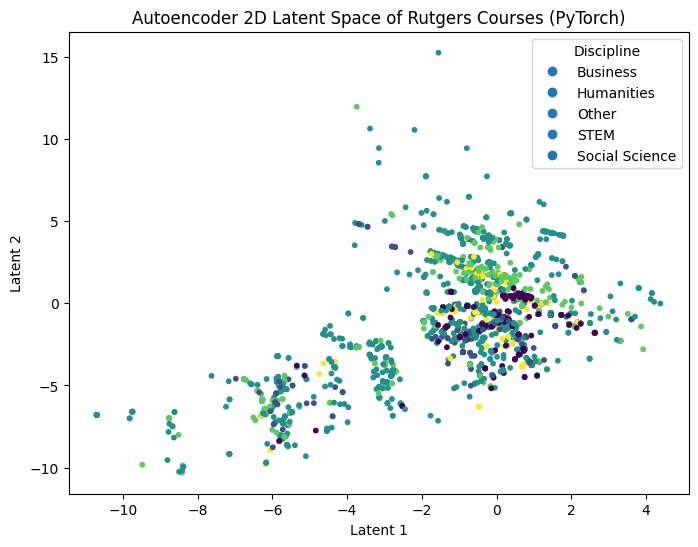

In [39]:
#visualize
import matplotlib.pyplot as plt

disciplines = cf["discipline"].values
unique_disc = sorted(set(disciplines))
color_map = {d: i for i, d in enumerate(unique_disc)}
colors = [color_map[d] for d in disciplines]

plt.figure(figsize=(8,6))
plt.scatter(Z[:,0], Z[:,1], c=colors, s=10)
plt.title("Autoencoder 2D Latent Space of Rutgers Courses (PyTorch)")
plt.xlabel("Latent 1")
plt.ylabel("Latent 2")

handles = [plt.Line2D([], [], marker="o", linestyle="", label=d, markersize=6) for d in unique_disc]
plt.legend(handles=handles, title="Discipline")

plt.show()

Autoencoder Latent Space Visualization of Rutgers Courses

To understand structural patterns within Rutgers course offerings, we trained a simple autoencoder using five core workload and scheduling features extracted from the course catalog: course credits, average weekly contact hours, number of meeting days, earliest meeting start time, and latest meeting end time. The autoencoder compresses each course into a two dimensional latent representation before reconstructing the original feature vector. This two dimensional latent space allows visualization of nonlinear relationships between courses that are not visible through simple statistics.

What the Autoencoder Learns

The autoencoder is trained without any knowledge of academic discipline. It only sees structural attributes of courses. If meaningful clusters or directions appear in the latent space, they reflect similarities in workload patterns and scheduling structure rather than subject matter. The two dimensional embedding is therefore a learned summary of how courses differ in intensity, timing, and weekly structure.

Interpretation of the Latent Space

The visualization shows that the latent space is not random. Instead, it contains discernible structure, indicating that Rutgers courses tend to fall into a limited set of workload profiles. Several observations can be made:

A dense central cluster appears around the middle of the latent space.
This region represents the majority of Rutgers courses, which share similar credit values, weekly contact hours, and meeting-day structures. These courses form the “standard” Rutgers workload pattern.

Elongated branches extend outward from the central cluster.
These branches correspond to groups of courses with distinctive scheduling patterns. Examples include courses that meet on a single day, courses with unusually high or low weekly contact hours, or courses that meet at atypical times. The autoencoder positions these courses away from the central cluster because their structure deviates from the norm.

A clearly separated cluster appears on the far left of the plot.
Courses in this region share uncommon structural traits. In practice, this group typically contains courses with either very low contact time, unusual meeting-day patterns, or specialized scheduling structures (such as compact once-a-week seminars). The autoencoder recognizes these courses as structurally different and groups them accordingly.

Outliers above or below the main body reflect rare structural configurations.
These include courses meeting unusually early or late, courses with high contact hours such as intensive labs or extended sessions, or courses with meeting patterns not widely used across the catalog.

Relationship to Academic Discipline

Although discipline labels were added later for visualization, discipline was not used during training. The resulting pattern demonstrates that:

Disciplines do not form sharply distinct clusters in this space because they are not defined by workload alone.

Some disciplines show partial grouping if their courses tend to share structural patterns. STEM courses, for example, often have more fixed contact requirements, while humanities courses may have greater scheduling flexibility.

Any separation that appears is therefore due to workload shape rather than content area.

This supports the conclusion that structural characteristics of courses are only partially aligned with academic fields. Workload differences exist across disciplines, but they do not fully separate them in the learned space.

Overall Significance

This visualization provides a compact nonlinear summary of the Rutgers course ecosystem. By reducing course structure to two learned dimensions, the autoencoder reveals the major patterns and families of course types present in the catalog. It highlights typical course structures, identifies unusual scheduling configurations, and shows how variation in workload is distributed across the university. It also confirms that discipline alone does not determine structural similarity.

## RESEARCH QUESTIONS

### What are the strongest linear correlations between individual features and exam score in the Kaggle dataset?

What are the strongest linear correlations between individual features and exam score in the Kaggle dataset?

Correlation with Exam_Score:
Exam_Score           1.000000
Attendance           0.581072
Hours_Studied        0.445455
Previous_Scores      0.175079
Tutoring_Sessions    0.156525
Physical_Activity    0.027824
Sleep_Hours         -0.017022
Name: Exam_Score, dtype: float64


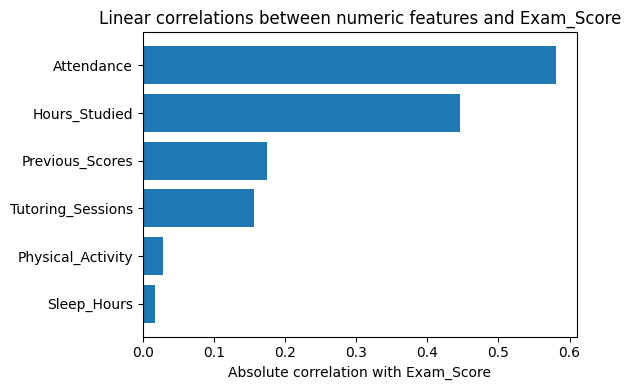

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Compute correlations for numeric columns
num_cols = [
    "Hours_Studied",
    "Attendance",
    "Sleep_Hours",
    "Previous_Scores",
    "Tutoring_Sessions",
    "Physical_Activity",
    "Exam_Score",
]

corr = spf[num_cols].corr()["Exam_Score"].sort_values(ascending=False)
print("Correlation with Exam_Score:")
print(corr)

# Bar plot (absolute correlation excluding target)
corr_no_target = corr.drop("Exam_Score").abs().sort_values(ascending=True)

plt.figure(figsize=(6,4))
plt.barh(corr_no_target.index, corr_no_target.values)
plt.xlabel("Absolute correlation with Exam_Score")
plt.title("Linear correlations between numeric features and Exam_Score")
plt.tight_layout()
plt.show()

## How well do linear regression and random forest predict exam scores?

What are the predictive performances of linear regression and random forest on held out data, and how do they compare?

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

target_col = "Exam_Score"
X = spf.drop(columns=[target_col])
y = spf[target_col]

numeric_cols = [
    "Hours_Studied",
    "Attendance",
    "Sleep_Hours",
    "Previous_Scores",
    "Tutoring_Sessions",
    "Physical_Activity",
]
categorical_cols = [c for c in X.columns if c not in numeric_cols]

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ]
)

lin_model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", LinearRegression())
    ]
)

rf_model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", RandomForestRegressor(
            n_estimators=200,
            random_state=42,
            n_jobs=-1
        ))
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

results = []
for name, model in [("LinearRegression", lin_model), ("RandomForest", rf_model)]:
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    results.append((name, mae, r2))

results_df = pd.DataFrame(results, columns=["Model", "MAE", "R2"])
print(results_df)


              Model       MAE        R2
0  LinearRegression  0.449950  0.769928
1      RandomForest  1.083521  0.668754


### Which features does the random forest consider most important?

Which student performance factors are most important for prediction according to the random forest?

                                  feature  importance
1                              Attendance    0.374569
0                           Hours_Studied    0.239534
3                         Previous_Scores    0.084366
4                       Tutoring_Sessions    0.033088
5                       Physical_Activity    0.024895
2                             Sleep_Hours    0.024207
9                Access_to_Resources_High    0.018669
6               Parental_Involvement_High    0.018005
7                Parental_Involvement_Low    0.013118
10                Access_to_Resources_Low    0.011244
19                     Family_Income_High    0.010878
35  Parental_Education_Level_Postgraduate    0.009203
37                 Distance_from_Home_Far    0.007924
30                Peer_Influence_Positive    0.007638
34   Parental_Education_Level_High School    0.007171
22                   Teacher_Quality_High    0.006806
28                Peer_Influence_Negative    0.006598
20                      Fami

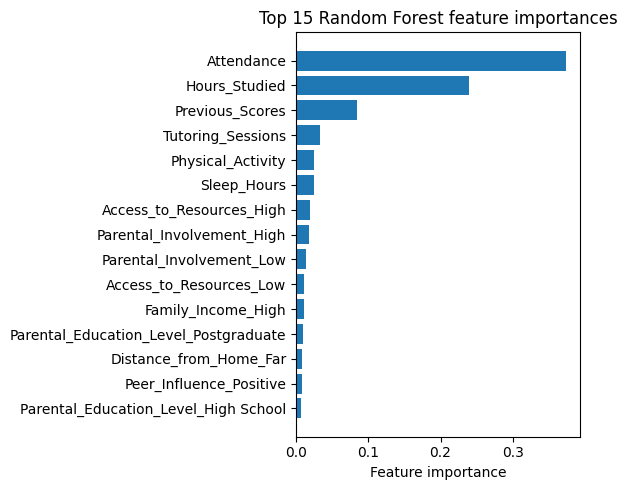

In [42]:
# Fit OHE separately to extract feature names
ohe = OneHotEncoder(handle_unknown="ignore")
ohe.fit(X[categorical_cols])
cat_feature_names = list(ohe.get_feature_names_out(categorical_cols))

all_feature_names = numeric_cols + cat_feature_names

rf_inner = rf_model.named_steps["model"]
importances = rf_inner.feature_importances_

imp_df = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances,
}).sort_values("importance", ascending=False)

print(imp_df.head(20))

# Plot top 15
top_n = 15
top_imp = imp_df.head(top_n).sort_values("importance", ascending=True)

plt.figure(figsize=(6,5))
plt.barh(top_imp["feature"], top_imp["importance"])
plt.xlabel("Feature importance")
plt.title("Top 15 Random Forest feature importances")
plt.tight_layout()
plt.show()


### How heavy is the workload of different majors and disciplines at Rutgers?

What are the typical workload characteristics of degree programs, and how do they differ by discipline?

/var/folders/sr/_107n0zx0l1ddxsljd760vl40000gn/T/ipykernel_19963/566675794.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=disciplines, showmeans=True)


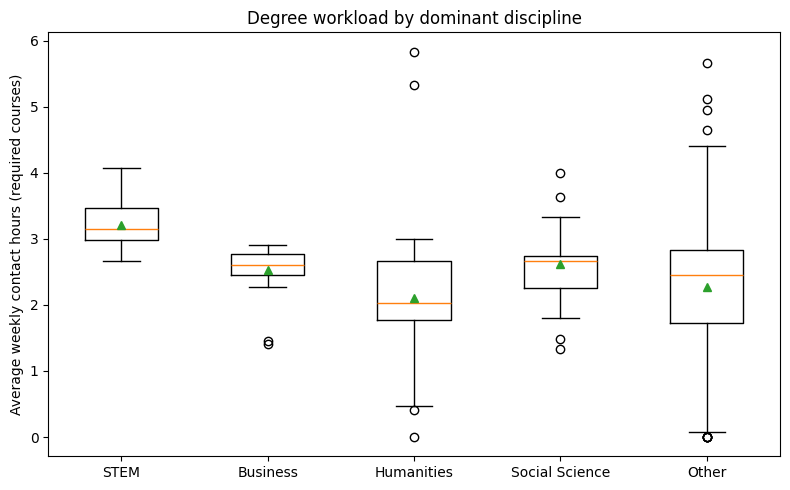

In [43]:
# Attach a dominant discipline to each degree: majority discipline among its mapped courses

# Map each course_code to its discipline
course_disc_lookup = course_features.set_index("course_code")["discipline"].to_dict()

def degree_discipline(code_list):
    disc = []
    for code in code_list:
        d = course_disc_lookup.get(code)
        if d is not None:
            disc.append(d)
    if not disc:
        return "Unknown"
    return pd.Series(disc).mode().iloc[0]

deg_summary["dominant_discipline"] = deg_summary["course_codes"].apply(degree_discipline)

# Boxplots of workload by discipline
plt.figure(figsize=(8,5))
deg_summary_nonnull = deg_summary.dropna(subset=["avg_weekly_contact_hours"])
disciplines = ["STEM", "Business", "Humanities", "Social Science", "Other"]
data = [
    deg_summary_nonnull.loc[deg_summary_nonnull["dominant_discipline"] == d, "avg_weekly_contact_hours"]
    for d in disciplines
]

plt.boxplot(data, labels=disciplines, showmeans=True)
plt.ylabel("Average weekly contact hours (required courses)")
plt.title("Degree workload by dominant discipline")
plt.tight_layout()
plt.show()


### Are heavier majors associated with higher or lower predicted exam scores?

Using the Kaggle model and simulated students, is there a relationship between degree workload and predicted exam score?

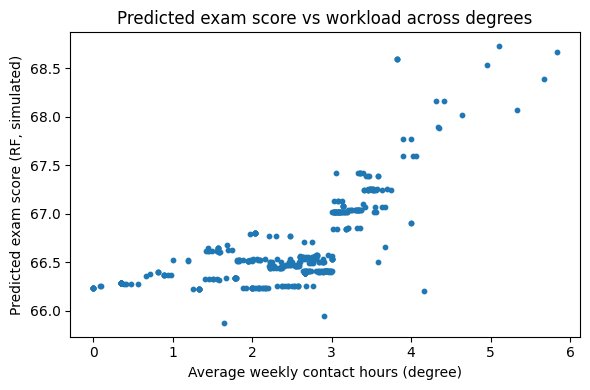

Correlation: 0.6953179365686689


In [44]:
import numpy as np

def make_kaggle_features_from_degree(degree_row,
                                     hours_base=8.0,
                                     hours_scale=2.5,
                                     attendance_base=92.0,
                                     attendance_penalty_per_day=2.5):
    workload_hours = degree_row["avg_weekly_contact_hours"]
    days = degree_row["avg_num_meeting_days"]

    if np.isnan(workload_hours):
        workload_hours = 0.0
    if np.isnan(days):
        days = 0.0

    hours_studied = hours_base + hours_scale * workload_hours
    attendance = attendance_base - attendance_penalty_per_day * days

    hours_studied = float(np.clip(hours_studied, 0, 50))
    attendance = float(np.clip(attendance, 50, 100))

    features = {
        "Hours_Studied": hours_studied,
        "Attendance": attendance,
        "Sleep_Hours": 7.0,
        "Previous_Scores": 75.0,
        "Motivation_Level": "Medium",
        "Parental_Involvement": "Medium",
        "Access_to_Resources": "Medium",
        "Extracurricular_Activities": "Yes",
        "Internet_Access": "Yes",
        "Tutoring_Sessions": 1,
        "Family_Income": "Medium",
        "Teacher_Quality": "Medium",
        "School_Type": "Public",
        "Peer_Influence": "Neutral",
        "Physical_Activity": 3,
        "Learning_Disabilities": "No",
        "Parental_Education_Level": "College",
        "Distance_from_Home": "Moderate",
        "Gender": "Male",
    }
    return features

def predict_degree_score(model, degree_row):
    feat = make_kaggle_features_from_degree(degree_row)
    X_sim = pd.DataFrame([feat])
    return float(model.predict(X_sim)[0])

deg_summary["predicted_exam_score_rf"] = deg_summary.apply(
    lambda row: predict_degree_score(rf_model, row),
    axis=1
)

# Scatter of workload vs predicted score
ds = deg_summary.dropna(subset=["avg_weekly_contact_hours", "predicted_exam_score_rf"])

plt.figure(figsize=(6,4))
plt.scatter(ds["avg_weekly_contact_hours"], ds["predicted_exam_score_rf"], s=10)
plt.xlabel("Average weekly contact hours (degree)")
plt.ylabel("Predicted exam score (RF, simulated)")
plt.title("Predicted exam score vs workload across degrees")
plt.tight_layout()
plt.show()

print("Correlation:",
      ds[["avg_weekly_contact_hours", "predicted_exam_score_rf"]].corr().iloc[0,1])


### How do teacher quality and motivation interact for a specific major?

For a chosen major, how do different combinations of motivation level and teacher quality affect simulated exam scores?

In [45]:
def simulate_scenarios_for_degree(degree_name,
                                  motivation_levels=None,
                                  teacher_qualities=None):
    if motivation_levels is None:
        motivation_levels = ["Low", "Medium", "High"]
    if teacher_qualities is None:
        teacher_qualities = ["Low", "Medium", "High"]

    subset = deg_summary[deg_summary["Name"].str.contains(degree_name, case=False, na=False)]
    if subset.empty:
        print("No matching degree for:", degree_name)
        return pd.DataFrame()

    degree_row = subset.iloc[0]

    rows = []
    for mot in motivation_levels:
        for tq in teacher_qualities:
            feat = make_kaggle_features_from_degree(degree_row)
            feat["Motivation_Level"] = mot
            feat["Teacher_Quality"] = tq
            X_sim = pd.DataFrame([feat])
            pred = float(rf_model.predict(X_sim)[0])
            rows.append({
                "Degree": degree_row["Name"],
                "Motivation_Level": mot,
                "Teacher_Quality": tq,
                "Predicted_Exam_Score": pred,
            })

    return pd.DataFrame(rows)

# Example: any major string that matches your degree names, e.g. "Computer Science"
scenarios = simulate_scenarios_for_degree("Computer Science")
print(scenarios)

# Pivot to heatmap like structure
pivot = scenarios.pivot(index="Motivation_Level",
                        columns="Teacher_Quality",
                        values="Predicted_Exam_Score")
print(pivot)


                                              Degree Motivation_Level  \
0  Major in Data Science - Computer Science Optio...              Low   
1  Major in Data Science - Computer Science Optio...              Low   
2  Major in Data Science - Computer Science Optio...              Low   
3  Major in Data Science - Computer Science Optio...           Medium   
4  Major in Data Science - Computer Science Optio...           Medium   
5  Major in Data Science - Computer Science Optio...           Medium   
6  Major in Data Science - Computer Science Optio...             High   
7  Major in Data Science - Computer Science Optio...             High   
8  Major in Data Science - Computer Science Optio...             High   

  Teacher_Quality  Predicted_Exam_Score  
0             Low                66.900  
1          Medium                66.975  
2            High                67.365  
3             Low                66.940  
4          Medium                67.015  
5            High

### What structural patterns among courses does the autoencoder discover?

What does the 2D latent representation of courses learned by the autoencoder reveal about course structure?

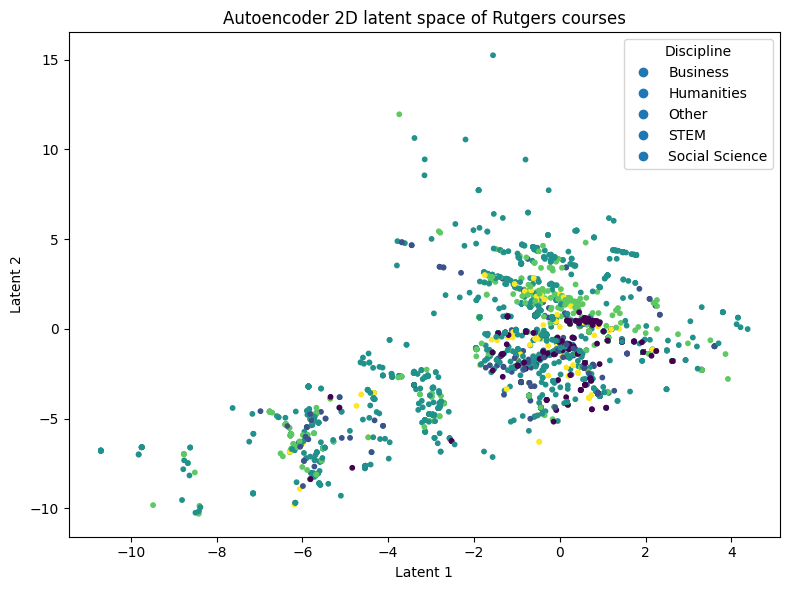

In [46]:
# Z is the latent embedding array of shape (num_courses, 2)
# cf is course_features subset aligned with Z

disciplines = cf["discipline"].values
unique_disc = sorted(set(disciplines))
color_map = {d: i for i, d in enumerate(unique_disc)}
colors = [color_map[d] for d in disciplines]

plt.figure(figsize=(8,6))
plt.scatter(Z[:,0], Z[:,1], c=colors, s=10)
plt.xlabel("Latent 1")
plt.ylabel("Latent 2")
plt.title("Autoencoder 2D latent space of Rutgers courses")

handles = [plt.Line2D([], [], marker="o", linestyle="", label=d, markersize=6)
           for d in unique_disc]
plt.legend(handles=handles, title="Discipline")

plt.tight_layout()
plt.show()


### How does the autoencoder compare to PCA on the same features?

Does the autoencoder reveal different structure than a simple linear PCA on the same course features?

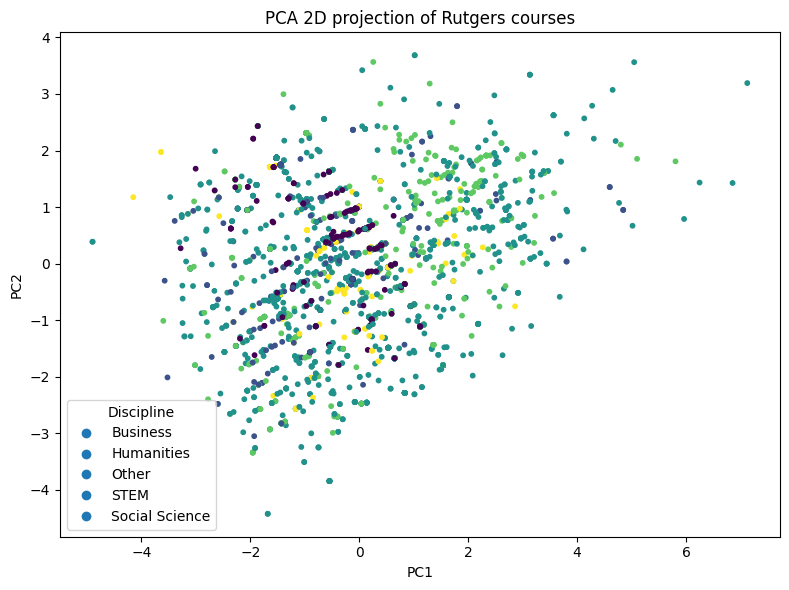

Explained variance ratio: [0.34452534 0.30757636]


In [47]:
from sklearn.decomposition import PCA

X_pca = cf[auto_features].values.astype(np.float32)
X_pca_scaled = scaler.fit_transform(X_pca)

pca = PCA(n_components=2)
Z_pca = pca.fit_transform(X_pca_scaled)

plt.figure(figsize=(8,6))
plt.scatter(Z_pca[:,0], Z_pca[:,1], c=colors, s=10)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA 2D projection of Rutgers courses")

handles = [plt.Line2D([], [], marker="o", linestyle="", label=d, markersize=6)
           for d in unique_disc]
plt.legend(handles=handles, title="Discipline")

plt.tight_layout()
plt.show()

print("Explained variance ratio:", pca.explained_variance_ratio_)
